## Importing Required Libraries & Dataset  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import boxplot, distplot
from pickle import dump

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Notebook settings
pd.set_option("display.max_columns", 40)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import dataset
df = pd.read_excel('flight_data.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Basic Data Visualization

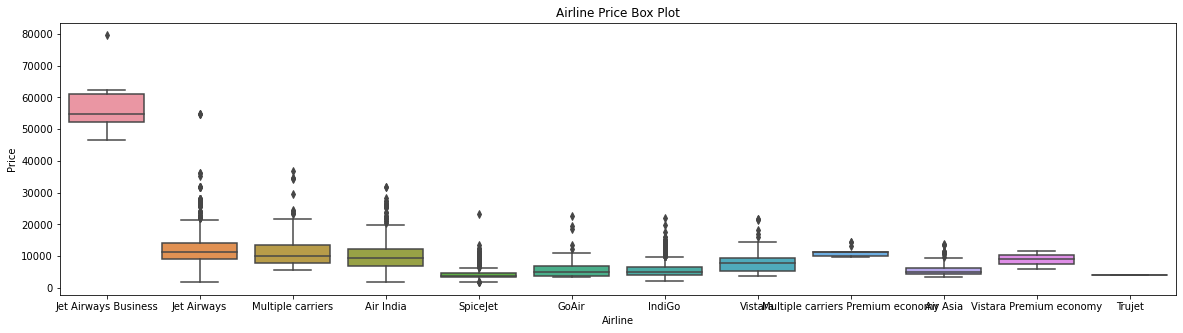

In [4]:
plt.figure(figsize=(20, 5))
boxplot(x='Airline', y='Price', data=df.sort_values('Price', ascending=False))
plt.title('Airline Price Box Plot')
plt.show()

## Data Preprocessing

### Removing Missing Values

In [5]:
print(df.isna().sum())
df.dropna(inplace=True)
assert sum(df.isna().sum()) == 0

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


### Handling Date & Time Related Features

In [6]:
# The columns related to date and time should be converted to appropriate date time objects for the ML model.
print(df.dtypes)
df.head()

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [7]:
columns = ['Date_of_Journey', 'Dep_Time', 'Arrival_Time']
for col in columns:
    df[col] = pd.to_datetime(df[col])  # Default Convert
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2021-06-29 22:20:00,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-06-29 05:50:00,2021-06-29 13:15:00,7h 25m,2 stops,No info,7662
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2021-06-29 09:25:00,2021-06-10 04:25:00,19h,2 stops,No info,13882
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2021-06-29 18:05:00,2021-06-29 23:30:00,5h 25m,1 stop,No info,6218
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2021-06-29 16:50:00,2021-06-29 21:35:00,4h 45m,1 stop,No info,13302


In [8]:
# Split date of journey into day and month columns
df['Journey_Day'] = df['Date_of_Journey'].dt.day
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df.drop('Date_of_Journey', axis=1, inplace=True)
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month
0,IndiGo,Banglore,New Delhi,BLR → DEL,2021-06-29 22:20:00,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-06-29 05:50:00,2021-06-29 13:15:00,7h 25m,2 stops,No info,7662,5,1
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2021-06-29 09:25:00,2021-06-10 04:25:00,19h,2 stops,No info,13882,6,9
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2021-06-29 18:05:00,2021-06-29 23:30:00,5h 25m,1 stop,No info,6218,5,12
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2021-06-29 16:50:00,2021-06-29 21:35:00,4h 45m,1 stop,No info,13302,3,1


In [9]:
# Extracting hour and minute values from departure, arrival times
# Processing Arrival Times
df['Arrival_Time_Hour'] = df['Arrival_Time'].dt.hour
df['Arrival_Time_Minute'] = df['Arrival_Time'].dt.minute
df.drop('Arrival_Time', axis=1, inplace=True)

# Processing Departure Times
df['Departure_Time_Hour'] = df['Dep_Time'].dt.hour
df['Departure_Time_Minute'] = df['Dep_Time'].dt.minute
df.drop('Dep_Time', axis=1, inplace=True)

df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Arrival_Time_Hour,Arrival_Time_Minute,Departure_Time_Hour,Departure_Time_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,1,10,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,13,15,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,4,25,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,23,30,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,21,35,16,50


In [10]:
# Convert duration feature to standard format -> {hours}h:{minutes}m
durations = list(df['Duration'])
for index, duration in enumerate(durations):
    n_values = duration.strip().split(' ')
    if len(n_values) != 2:
        if duration[-1] == 'h':
            durations[index] = duration + " 0m"  # Only hour value given, append 0 minutes
        else:
            durations[index] = "0h " + duration  # Only minute value given, add 0 hours
df['Duration'] = durations

# Split duration column in hours and minutes
df['Duration_Hours'] = df['Duration'].apply(lambda x: int(x.split(' ')[0][:-1]))
df['Duration_Minutes'] = df['Duration'].apply(lambda x: int(x.split(' ')[1][:-1]))
df.drop('Duration', axis=1, inplace=True)
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Arrival_Time_Hour,Arrival_Time_Minute,Departure_Time_Hour,Departure_Time_Minute,Duration_Hours,Duration_Minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,1,10,22,20,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,13,15,5,50,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,4,25,9,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,23,30,18,5,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,21,35,16,50,4,45


### Splitting Routes Feature

In [11]:
# Determining maximum number of stops in the dataset
max_stops = max([route.count('→')+1 for route in df['Route']])
print('Maximum number of stops:', max_stops)

for i in range(max_stops):
    df[f'Route_{i}'] = df['Route'].str.split('→').str[i]

df.drop('Route', axis=1, inplace=True)

# Convert NaN values to None
for i in range(max_stops):
    df[f'Route_{i}'].fillna('None', inplace=True)

df.head()

Maximum number of stops: 6


,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Arrival_Time_Hour,Arrival_Time_Minute,Departure_Time_Hour,Departure_Time_Minute,Duration_Hours,Duration_Minutes,Route_0,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,24,3,1,10,22,20,2,50,BLR,DEL,None,None,None,None
1,Air India,Kolkata,Banglore,2 stops,No info,7662,5,1,13,15,5,50,7,25,CCU,IXR,BBI,BLR,None,None
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,6,9,4,25,9,25,19,0,DEL,LKO,BOM,COK,None,None
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,5,12,23,30,18,5,5,25,CCU,NAG,BLR,None,None,None
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,3,1,21,35,16,50,4,45,BLR,NAG,DEL,None,None,None


### Feature Encoding

In [12]:
# Features that require encoding
categorical_columns = df.select_dtypes(include='object').columns
print(categorical_columns)

# Drop additional info column
df.drop('Additional_Info', axis=1, inplace=True)

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'Route_0', 'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5'],
      dtype='object')


In [13]:
# One hot encoding source, destination and airline features
source = pd.get_dummies(df['Source'], drop_first=True)
destination = pd.get_dummies(df['Destination'], drop_first=True)
airlines = pd.get_dummies(df['Airline'], drop_first=True)

df = pd.concat([df, source, destination, airlines], axis=1)

df.drop('Airline', axis=1, inplace=True)
df.drop('Source', axis=1, inplace=True)
df.drop('Destination', axis=1, inplace=True)
df.head()

,Total_Stops,Price,Journey_Day,Journey_Month,Arrival_Time_Hour,Arrival_Time_Minute,Departure_Time_Hour,Departure_Time_Minute,Duration_Hours,Duration_Minutes,Route_0,Route_1,Route_2,Route_3,Route_4,Route_5,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,non-stop,3897,24,3,1,10,22,20,2,50,BLR,DEL,None,None,None,None,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,2 stops,7662,5,1,13,15,5,50,7,25,CCU,IXR,BBI,BLR,None,None,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2 stops,13882,6,9,4,25,9,25,19,0,DEL,LKO,BOM,COK,None,None,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1 stop,6218,5,12,23,30,18,5,5,25,CCU,NAG,BLR,None,None,None,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1 stop,13302,3,1,21,35,16,50,4,45,BLR,NAG,DEL,None,None,None,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [14]:
# Label encoding Total_Stops feature using a map
print(df['Total_Stops'].unique())
stops_map = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
df['Total_Stops'] = df['Total_Stops'].map(stops_map)
df.head()

['non-stop' '2 stops' '1 stop' '3 stops' '4 stops']


,Total_Stops,Price,Journey_Day,Journey_Month,Arrival_Time_Hour,Arrival_Time_Minute,Departure_Time_Hour,Departure_Time_Minute,Duration_Hours,Duration_Minutes,Route_0,Route_1,Route_2,Route_3,Route_4,Route_5,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,3897,24,3,1,10,22,20,2,50,BLR,DEL,None,None,None,None,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,2,7662,5,1,13,15,5,50,7,25,CCU,IXR,BBI,BLR,None,None,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,13882,6,9,4,25,9,25,19,0,DEL,LKO,BOM,COK,None,None,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,6218,5,12,23,30,18,5,5,25,CCU,NAG,BLR,None,None,None,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,13302,3,1,21,35,16,50,4,45,BLR,NAG,DEL,None,None,None,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [15]:
# Label encoding Route features
route_cols = [col for col in df.columns if col.startswith('Route')]
encoder = LabelEncoder()
for i in route_cols:
    df[i] = encoder.fit_transform(df[i])
df.head()

,Total_Stops,Price,Journey_Day,Journey_Month,Arrival_Time_Hour,Arrival_Time_Minute,Departure_Time_Hour,Departure_Time_Minute,Duration_Hours,Duration_Minutes,Route_0,Route_1,Route_2,Route_3,Route_4,Route_5,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,3897,24,3,1,10,22,20,2,50,0,13,29,13,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,2,7662,5,1,13,15,5,50,7,25,2,25,1,3,5,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,13882,6,9,4,25,9,25,19,0,3,32,4,5,5,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,6218,5,12,23,30,18,5,5,25,2,34,3,13,5,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,13302,3,1,21,35,16,50,4,45,0,34,8,13,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


### Handling Outliers

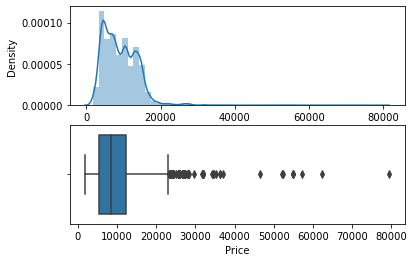

In [16]:
# Plotting price distribution
fig, (ax1, ax2) = plt.subplots(2, 1)
distplot(df['Price'], ax=ax1)
boxplot(df['Price'], ax=ax2)
plt.show()

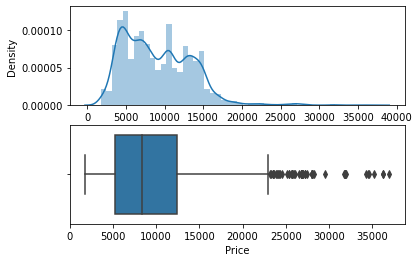

In [17]:
# Replace outlier price values with median price value
df['Price'] = np.where(df['Price'] >= 40000, df['Price'].median(), df['Price'])
fig, (ax1, ax2) = plt.subplots(2, 1)
distplot(df['Price'], ax=ax1)
boxplot(df['Price'], ax=ax2)
plt.show()

### Split Dataset into Features (X) and Value (Y)

In [18]:
X = df.drop('Price', axis=1)
y = df['Price']

print('Features Shape:\t', X.shape)
print('Values Shape:\t', y.shape)

Features Shape:	 (10682, 35)
Values Shape:	 (10682,)


### Feature Selection

In [19]:
features = pd.DataFrame(mutual_info_classif(X, y), index=X.columns)
features.columns = ['Importance']
features.sort_values(by='Importance', ascending=False, inplace=False)

,Importance
Route_1,2.792836
Route_2,2.281929
Total_Stops,2.145100
Route_0,2.067408
Arrival_Time_Hour,1.856373
Route_5,1.789114
Duration_Hours,1.772035
Cochin,1.573354
Delhi,1.567416
Arrival_Time_Minute,1.546862


### Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Machine Learning Models

In [21]:
def predict(ml_model, dump_model=False):
    model = ml_model.fit(X_train, y_train)
    print("Model: {}".format(model.__class__.__name__))
    print("Training Score: {}".format(model.score(X_train, y_train)))
    y_pred = model.predict(X_test)

    r2_score = metrics.r2_score(y_test, y_pred)
    print("R² Score: {}".format(r2_score))

    print("Mean Absolute Error: {}".format(metrics.mean_absolute_error(y_test, y_pred)))
    print("Mean Squared Error: {}".format(metrics.mean_squared_error(y_test, y_pred)))
    print("Root Mean Squared Error: {}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    
    distplot(y_test-y_pred)

    if dump_model:
        file = open("{}.pkl".format(model.__class__.__name__), "wb")
        dump(model, file)

Model: RandomForestRegressor
Training Score: 0.9543765005702377
R² Score: 0.8142869906104524
Mean Absolute Error: 1143.589780365088
Mean Squared Error: 3600023.051391729
Root Mean Squared Error: 1897.3726706663952


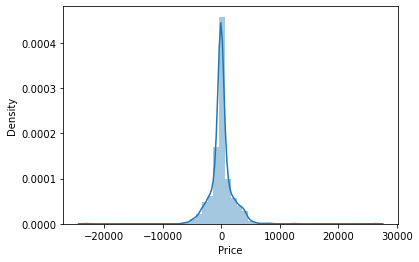

In [22]:
predict(RandomForestRegressor())

Model: LinearRegression
Training Score: 0.611709402920433
R² Score: 0.6316952795288937
Mean Absolute Error: 1918.342259956807
Mean Squared Error: 7139540.132329551
Root Mean Squared Error: 2671.991791216723


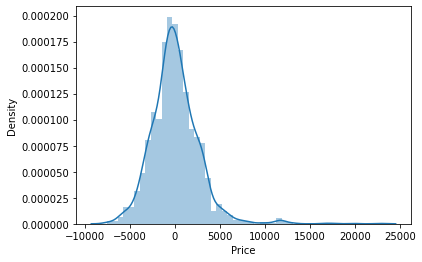

In [23]:
predict(LinearRegression())

Model: KNeighborsRegressor
Training Score: 0.7796931490334607
R² Score: 0.6597272290101369
Mean Absolute Error: 1725.8729995320543
Mean Squared Error: 6596144.359251287
Root Mean Squared Error: 2568.2960030439026


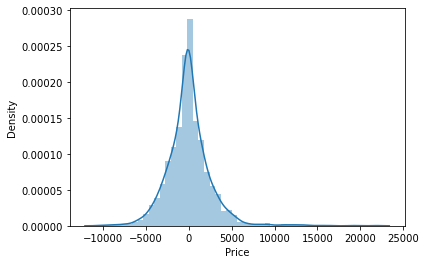

In [24]:
predict(KNeighborsRegressor())

Model: DecisionTreeClassifier
Training Score: 0.8849619660620246
R² Score: 0.6757406443626329
Mean Absolute Error: 1388.5184838558728
Mean Squared Error: 6285726.340664483
Root Mean Squared Error: 2507.135086241761


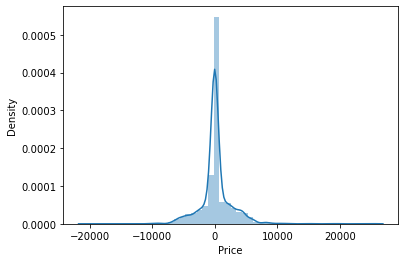

In [25]:
predict(DecisionTreeClassifier())

## Model Optimization using Hyperparameter Tuning

In [26]:
rgr = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=6)]
max_depth = [int(x) for x in np.linspace(start=5, stop=30, num=4)]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt'],
    'max_depth': max_depth,
    'min_samples_split': [5, 10, 15, 100]
}

In [27]:
# Estimating best parameters
rf_random = RandomizedSearchCV(estimator=rgr, param_distributions=random_grid, cv=3, verbose=2, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 320, 540, 760,
                                                         980, 1200]},
                   verbose=2)

In [28]:
print(rf_random.best_params_)
y_pred = rf_random.predict(X_test)

{'n_estimators': 760, 'min_samples_split': 15, 'max_features': 'auto', 'max_depth': 30}


R² Score: 0.8387619222560179


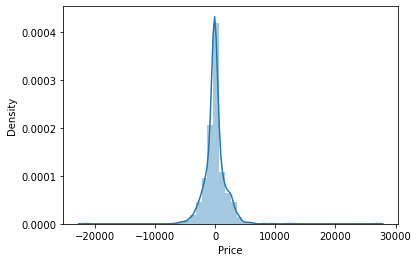

In [29]:
# Metrics for optimized model
distplot(y_test-y_pred)
print("R² Score:", metrics.r2_score(y_test, y_pred))